<a href="https://colab.research.google.com/github/KoreTane/An-lise-GLP/blob/main/An%C3%A1lisePre%C3%A7oGLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.3-py2.py3-none-any.whl size=317840625 sha256=10b6b8aff5f22ee2a0b0d4720505074b66b420e6b801c1b18409b2e307cc0a15
  Stored in directory: /root/.cache/pip/wheels/1b/3a/92/28b93e2fbfdbb07509ca4d6f50c5e407f48dce4ddbda69a4ab
Successfully built pyspark


In [1]:
from pyspark.sql import SparkSession
from google.colab import drive
from pyspark.sql import functions as F
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

drive.mount('/content/drive')

spark = SparkSession.builder \
    .appName("Análise de Preços do GLP") \
    .getOrCreate()

# Caminho para a pasta no Google Drive onde os arquivos Parquet estão armazenados
#(convertemos anteriormente do formato CVS => parquet para melhoramos a eficiência de armazenamento e a velocidade de leitura
# permitindo análises mais rápidas e economizando espaço em disco)

parquet_folder_path = '/content/drive/My Drive/1dhA5CNHrywBWHxOgPRyLalCBmNVbCLof/'

# Lista de arquivos Parquet
parquet_files = [
    'glp2023-01.parquet',
    'glp2023-02.parquet',
    'glp2024-01.parquet',
    'precosglp2024-07.parquet',
    'precosglp2024-08.parquet'
]

parquet_dataframes = {
    file: spark.read.parquet(f'{parquet_folder_path}{file}')
    for file in parquet_files
}

union_df = (
    parquet_dataframes['glp2023-01.parquet']
    .union(parquet_dataframes['glp2023-02.parquet'])
    .union(parquet_dataframes['glp2024-01.parquet'])
    .union(parquet_dataframes['precosglp2024-07.parquet'])
    .union(parquet_dataframes['precosglp2024-08.parquet'])
)

print("Dados do DataFrame unido:")
union_df.printSchema()

union_df.describe().show()

union_df.show(10, truncate=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dados do DataFrame unido:
root
 |-- Regiao - Sigla: string (nullable = true)
 |-- Estado - Sigla: string (nullable = true)
 |-- Municipio: string (nullable = true)
 |-- Revenda: string (nullable = true)
 |-- CNPJ da Revenda: string (nullable = true)
 |-- Nome da Rua: string (nullable = true)
 |-- Numero Rua: string (nullable = true)
 |-- Complemento: string (nullable = true)
 |-- Bairro: string (nullable = true)
 |-- Cep: string (nullable = true)
 |-- Produto: string (nullable = true)
 |-- Data da Coleta: string (nullable = true)
 |-- Valor de Venda: string (nullable = true)
 |-- Valor de Compra: string (nullable = true)
 |-- Unidade de Medida: string (nullable = true)
 |-- Bandeira: string (nullable = true)

+-------+--------------+--------------+----------+--------------------+-------------------+--------------------+------------------+-----------------+---

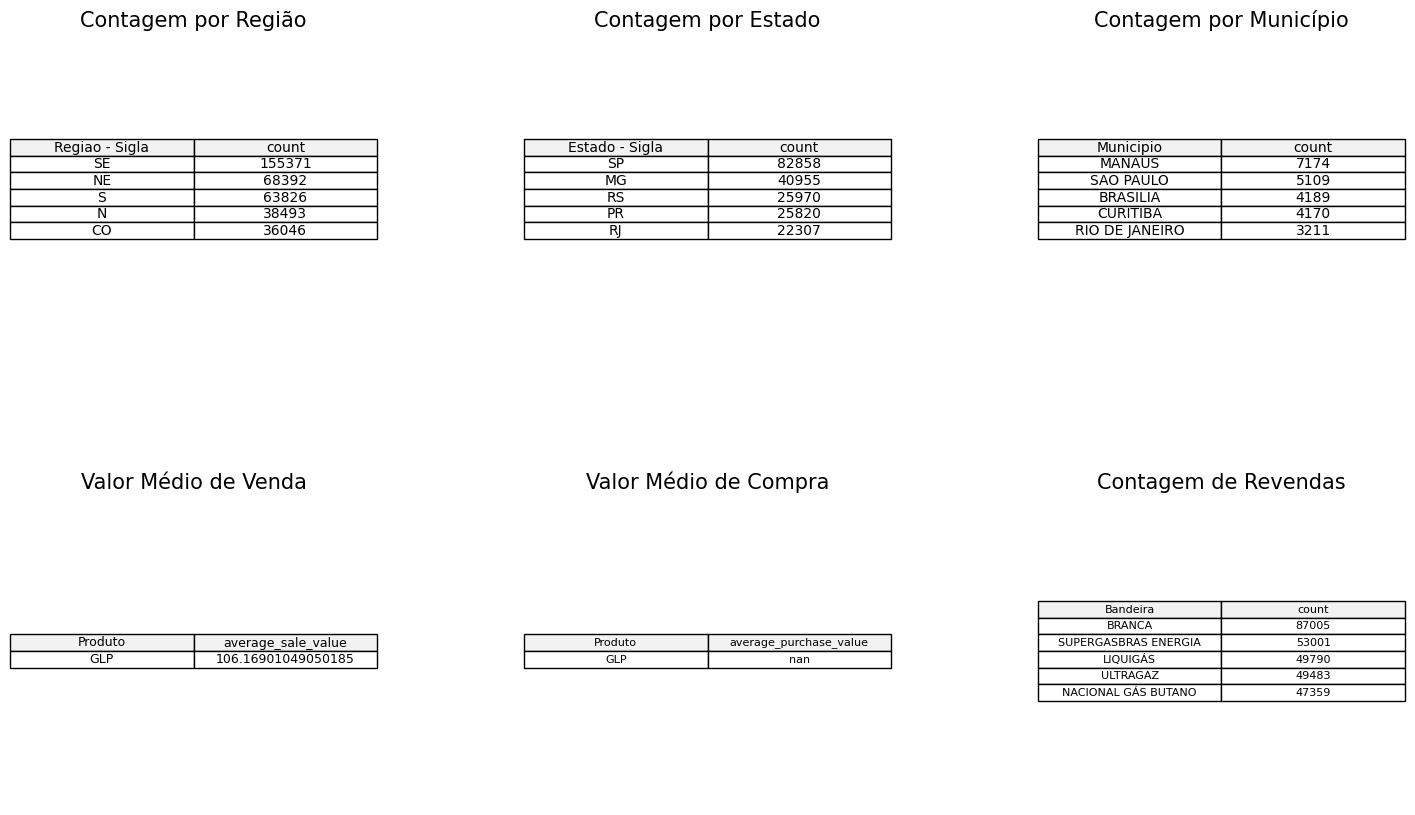

In [15]:
# Coletar os resultados em DataFrames do Pandas
region_count_pd = region_count.toPandas()
state_count_pd = state_count.toPandas()
municipio_count_pd = municipio_count.toPandas()
avg_sale_value_pd = avg_sale_value.toPandas()
avg_purchase_value_pd = avg_purchase_value.toPandas()
revenda_count_pd = revenda_count.toPandas()
data_count_pd = data_count.toPandas()

# Criar uma figura com subplots
fig, axs = plt.subplots(2, 3, figsize=(18, 10))  # 2 linhas, 3 colunas

# Ajustar o espaçamento entre os subplots
plt.subplots_adjust(wspace=0.4, hspace=0.5)

# Exibir os resultados nas subplots
axs[0, 0].axis('off')
axs[0, 0].set_title("Contagem por Região", fontsize=15)
axs[0, 0].table(cellText=region_count_pd.head(5).values,
                colLabels=region_count_pd.columns,
                cellLoc='center', loc='center', colColours=["#f2f2f2"]*len(region_count_pd.columns))

axs[0, 1].axis('off')
axs[0, 1].set_title("Contagem por Estado", fontsize=15)
axs[0, 1].table(cellText=state_count_pd.head(5).values,
                colLabels=state_count_pd.columns,
                cellLoc='center', loc='center', colColours=["#f2f2f2"]*len(state_count_pd.columns))

axs[0, 2].axis('off')
axs[0, 2].set_title("Contagem por Município", fontsize=15)
axs[0, 2].table(cellText=municipio_count_pd.head(5).values,
                colLabels=municipio_count_pd.columns,
                cellLoc='center', loc='center', colColours=["#f2f2f2"]*len(municipio_count_pd.columns))

axs[1, 0].axis('off')
axs[1, 0].set_title("Valor Médio de Venda", fontsize=15)
axs[1, 0].table(cellText=avg_sale_value_pd.head(5).values,
                colLabels=avg_sale_value_pd.columns,
                cellLoc='center', loc='center', colColours=["#f2f2f2"]*len(avg_sale_value_pd.columns))

axs[1, 1].axis('off')
axs[1, 1].set_title("Valor Médio de Compra", fontsize=15)
axs[1, 1].table(cellText=avg_purchase_value_pd.head(5).values,
                colLabels=avg_purchase_value_pd.columns,
                cellLoc='center', loc='center', colColours=["#f2f2f2"]*len(avg_purchase_value_pd.columns))

axs[1, 2].axis('off')
axs[1, 2].set_title("Contagem de Revendas", fontsize=15)
axs[1, 2].table(cellText=revenda_count_pd.head(5).values,
                colLabels=revenda_count_pd.columns,
                cellLoc='center', loc='center', colColours=["#f2f2f2"]*len(revenda_count_pd.columns))

# Exibir a tabela
plt.show()